In [1]:
%pip install pvlib --quiet

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Documents\irradiance\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import h5py
from tqdm import tqdm
import scipy.stats as stats

sys.path.append('..')

from src.data import load_data
from src.utils import convert_pixel_to_coordinates
from src import config

In [2]:
from pvlib import pvsystem, location, modelchain

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


,ghi,dni,dhi
2019-01-01 06:00:00-05:00,751.226636,692.940107,193.908657
2019-01-01 06:05:00-05:00,757.398914,695.264251,194.601581
2019-01-01 06:10:00-05:00,763.077687,697.382474,195.235361
2019-01-01 06:15:00-05:00,768.259693,699.298823,195.810617
2019-01-01 06:20:00-05:00,772.941968,701.016930,196.327902


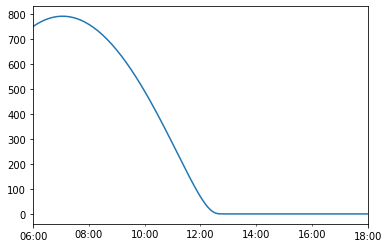

In [9]:
loc = location.Location(10, 0)
times = pd.date_range(
    "2019-01-01 06:00", "2019-01-01 18:00", freq="5min", tz="Etc/GMT+5"
)
weather = loc.get_clearsky(times)
weather.ghi.plot()
weather.head()

In [10]:
def search_day_max(loc_x: int, loc_y: int, day: str = "2019-01-01"):
    """Search the max for one day."""
    lat, long = convert_pixel_to_coordinates(loc_x, loc_y)
    loc = location.Location(lat, long)
    times = pd.date_range(
        f"{day} 06:00", f"{day} 22:00", freq="1h", tz="Etc/GMT+5"
    )
    weather = loc.get_clearsky(times)
    return weather.ghi.max()
    

In [16]:
africa = np.zeros((config.RAW_DATA_WIDTH, config.RAW_DATA_HEIGHT))

size = 10
with tqdm(total=int(config.RAW_DATA_HEIGHT * config.RAW_DATA_WIDTH)/size**2) as pbar:
    for x in range(0, config.RAW_DATA_WIDTH, size):
        for y in range(0, config.RAW_DATA_HEIGHT, size):
            val = search_day_max(x, y)
            africa[y:y+size, x:x+size] = val
            pbar.update(1)


1482it [01:01, 24.13it/s]                             


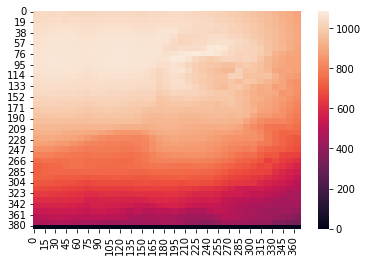

In [17]:
sns.heatmap(africa);